In [1]:
# Example performance of HMM-based realignment:

%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from copy import deepcopy
import glob, sys


[sys.path.append(f) for f in glob.glob('../utils/*')]
from preprocess import DataStruct
from plotting_utils import figSize
from lineplots import plotsd
from hmm_utils import *
from hmm import *
from session_utils import *
from recalibration_utils import *

from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.decomposition import FactorAnalysis, PCA


data_dir    = '/oak/stanford/groups/shenoy/gwilson/nonstationarities/'
fig_path    = '/home/users/ghwilson/projects/nonstationarities/figures/'
participant = 'T5/historical/'
min_nblocks = 3

# preprocess by selecting sessions with a minimal block count:
files       = loadDataset(data_dir, participant)
files       = get_Sessions(files, min_nblocks, manually_remove = None)

### train RNN on day 0, get baseline performance measure


In [2]:
import torch
import models

def convert_to_seqs(data, seqlen):
    '''Chop up array into smaller arrays of length <seqlen>'''
    nSeqs = int(data.shape[0] / seqlen)
    seqs  = np.array_split(data, nSeqs, axis = 0)
    
    return seqs


def prepareSessionForRNN(file, cfg):
    '''Prep session data for RNN'''
    
    session       = DataStruct(file, alignScreens = True, causal_filter = cfg['sigma'])

    train_x, test_x, train_y, test_y  = getTrainTest(session, train_size = cfg['train_size'], task = cfg['task'], 
                                                     blocks = cfg['blocks'], returnFlattened = True)
    
    train_x, test_x  = get_BlockwiseMeanSubtracted(train_x, test_x, concatenate = True)
    train_y          = np.concatenate(train_y)
    test_y           = np.concatenate(test_y)

    # standardize velocities to be in [-1, 1]
    ymax     = max(np.max(train_y), np.max(test_y))
    train_y /= ymax
    test_y  /= ymax

    # normalize input features
    thresh   = np.percentile(train_x, 99) * 2 
    test_x[np.abs(test_x) > thresh] = thresh * np.sign(test_x[np.abs(test_x) > thresh])

    input_sd = np.std(train_x, axis = 0)
    train_x[:, input_sd != 0] /= input_sd[None, input_sd != 0]
    test_x[:, input_sd != 0]  /= input_sd[None, input_sd != 0]

    # generate sequences to support minibatch training 
    x_train  = convert_to_seqs(train_x, seqlen = cfg['seqlen'])
    y_train  = convert_to_seqs(train_y, seqlen = cfg['seqlen'])

    x_val    = [test_x]
    y_val    = [test_y] 
    
    return x_train, y_train, x_val, y_val
    
    
def addRandomWalk(timeseries, strength):
    '''Apply mean drift to timeseries data using autoregressive noise'''
    nSamples, nChannels = timeseries.shape
    noise               = np.zeros(timeseries.shape)
    noise[0, :]         = np.random.normal(0, strength, size = nChannels)
    for t in range(1, nSamples):
        noise[t, :] = noise[t-1, :] + np.random.normal(0, strength, size = nChannels)  
        
    return timeseries + noise

def addWhiteNoise(timeseries, strength):
    noise = np.random.normal(0, strength, size = timeseries.shape)    
    return timeseries + noise

def addOffset(timeseries, strength):
    offset      = np.random.normal(0, strength, size = timeseries.shape[1])  
    return timeseries + offset

def addNoise(timeseries, offset_strength = 0, whitenoise_strength = 0, randomwalk_strength = 0):   
    if offset_strength > 0:
        timeseries = addOffset(timeseries, strength = offset_strength)
    if whitenoise_strength > 0:
        timeseries = addWhiteNoise(timeseries, strength = offset_strength)
    if randomwalk_strength > 0:
        timeseries = addRandomWalk(timeseries, strength = randomwalk_strength) 
        
    return timeseries

In [3]:
# Get initial day performance and decoder:
cfg = dict()
cfg['train_size'] = 0.67
cfg['task']       = None
cfg['blocks']     = None
cfg['sigma']      = 2
cfg['seqlen']     = 900

x_train, y_train, x_val, y_val = prepareSessionForRNN(files[2], cfg)


/share/software/user/open/py-scikit-learn/0.19.1_py36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [60]:
torch.cuda.empty_cache()
np.random.seed(42)       # make reproducible
torch.manual_seed(42)    # make reproducible


input_size    = 192
hidden_size   = 20
output_size   = 2
n_layers      = 1
dropout       = 0.5


model       = models.LSTM2(input_size, hidden_size, output_size, n_layers = n_layers, dropout = dropout).double()
optimizer   = torch.optim.Adam(model.parameters(), lr= 0.008)
DEVICE      = torch.device("cuda:{}".format(0) if torch.cuda.is_available() else "cpu")
print('Using device: ', torch.cuda.get_device_name(0))
model.to(DEVICE)

Using device:  Tesla V100-SXM2-32GB


LSTM2(
  (dropout): Dropout(p=0.5, inplace=False)
  (rnn): LSTM(192, 20)
  (linear): Linear(in_features=20, out_features=2, bias=True)
)

In [69]:
import model_utils

n_epochs    = 100
print_every = 5
batch_size  = 50

offset_strength     = 0.3
whitenoise_strength = 0.1
randomwalk_strength = 0.02

loss_curves = [[], []]

for epoch in range(1, n_epochs + 1):
    x_train_perturbed = [addNoise(x, offset_strength, whitenoise_strength, randomwalk_strength) for x in x_train]
    w_train = [np.ones(y.shape) for y in y_train]
    model_utils.trainRNN(model, optimizer, x_train_perturbed, y_train, w_list = w_train, batch_size = batch_size, shuffle = True, DEVICE = DEVICE)
    if epoch % print_every == 0:
        train_loss = model_utils.evaluateRNN(model, x_train, y_train, batch_size, DEVICE = DEVICE)
        val_loss   = model_utils.evaluateRNN(model, x_val, y_val, batch_size, DEVICE = DEVICE)

        loss_curves[0].append(train_loss)
        loss_curves[1].append(val_loss)
        print('----------Epoch ', epoch, ' -------------')
        print('Train loss: ', train_loss)
        print('Val loss: ', val_loss)

----------Epoch  5  -------------
Train loss:  0.03076472923274334
Val loss:  0.040742857923719074
----------Epoch  10  -------------
Train loss:  0.029980437369149453
Val loss:  0.038215736767683965
----------Epoch  15  -------------
Train loss:  0.028365773209261435
Val loss:  0.03712727953495391
----------Epoch  20  -------------
Train loss:  0.026554186902268084
Val loss:  0.03483204952334188
----------Epoch  25  -------------
Train loss:  0.02611837759602975
Val loss:  0.03481530458516196
----------Epoch  30  -------------
Train loss:  0.025016145386346018
Val loss:  0.03372170865039143
----------Epoch  35  -------------
Train loss:  0.024343252203414052
Val loss:  0.0338223879649828
----------Epoch  40  -------------
Train loss:  0.02375380761967023
Val loss:  0.033162186826926406
----------Epoch  45  -------------
Train loss:  0.02326979809702649
Val loss:  0.03309666754850509
----------Epoch  50  -------------
Train loss:  0.022591472360964565
Val loss:  0.0323725402580869
----

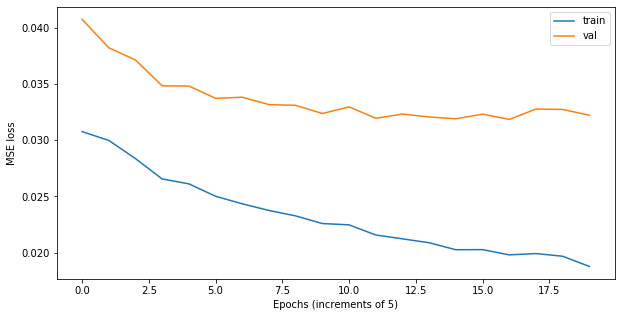

In [70]:
figSize(5, 10)

plt.figure()
for i, label in enumerate(['train', 'val']):
    plt.plot(loss_curves[i], label = label)

plt.legend()
plt.ylabel('MSE loss')
plt.xlabel('Epochs (increments of ' + str(print_every) + ')')
plt.show()

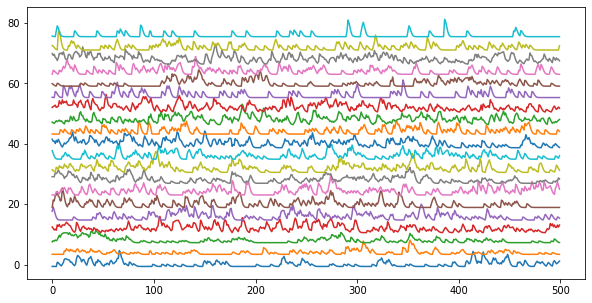

In [71]:
_ = plt.plot(x_val[0][:500, :20] + np.arange(20) * 4)
plt.savefig(fig_path + 'RNN/rnn_example_neural.pdf')
plt.show()

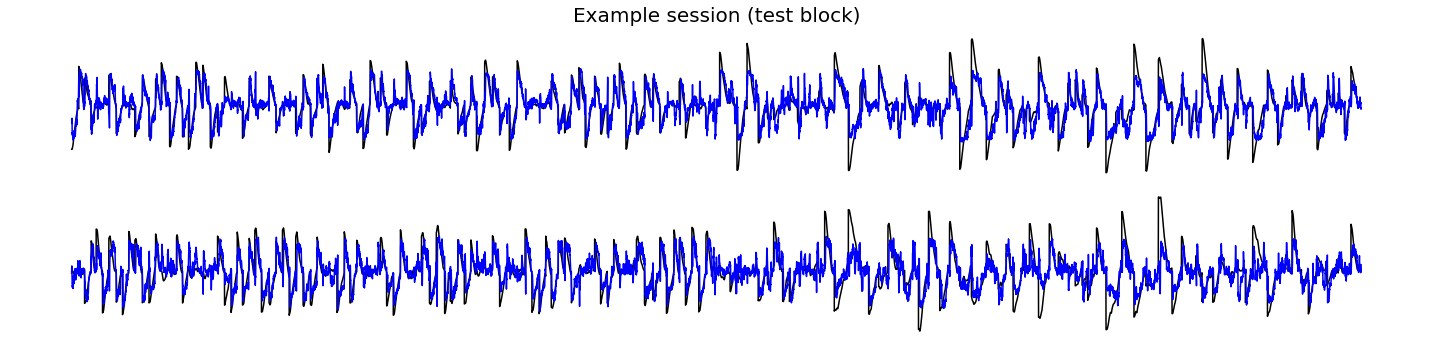

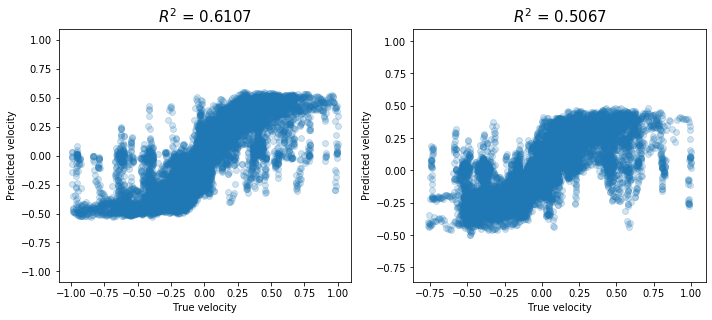

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score

model.eval()
preds  = model_utils.predictRNN(model, x_val, DEVICE = DEVICE)

figSize(5, 20)

plt.figure(1)
trl = 0

for i in range(output_size):
    x = y_val[trl][:, i]
    y = preds[trl].squeeze()[:, i]
    
    plt.subplot(output_size, 1, i + 1)
    _ = plt.plot(x, color = 'k')
    plt.axis('off')
    _ = plt.plot(y, color = 'b')

plt.tight_layout(rect=[0, 0.03, 1, 0.94])
plt.suptitle('Example session (test block)', fontsize = 20)

plt.savefig(fig_path + 'RNN/rnn_example.pdf')


figSize(5, 10)

plt.figure(2)
for i in range(output_size):
    x = y_val[trl][:, i]
    y = preds[trl].squeeze()[:, i]
    
    plt.subplot(1, 2,  i + 1)
    plt.scatter(x, y, alpha = 0.2)
    minval = min(x.min(), y.min()) - 0.1
    maxval = max(x.max(), y.max()) + 0.1
    plt.xlim([minval, maxval])
    plt.ylim([minval, maxval])
    plt.xlabel('True velocity')
    plt.ylabel('Predicted velocity')
    plt.title('$R^2$ = ' + str(np.round(r2_score(x, y), 4)), fontsize = 15)

plt.tight_layout(rect=[0, 0.03, 1, 0.94])

#plt.savefig(fig_path + 'RNN/rnn_example.pdf')

plt.show()

### test RNN and linear decoder on each day

In [ ]:
import model_utils

np.random.seed(42)       # make reproducible
torch.manual_seed(42)    # make reproducible

# Get initial day performance and decoder:
cfg = dict()
cfg['train_size'] = 0.67
cfg['task']       = None
cfg['blocks']     = None
cfg['sigma']      = 2
cfg['seqlen']     = 900


scores_dict = dict()
scores_dict['RNN']    = np.zeros((len(files), ))
scores_dict['linear'] = np.zeros((len(files), ))

for i, file in enumerate(files):

    x_train, y_train, x_val, y_val = prepareSessionForRNN(file, cfg)
    torch.cuda.empty_cache()

    input_size    = 192
    hidden_size   = 20
    output_size   = 2
    n_layers      = 1
    dropout       = 0.1
    
    offset_strength     = 0.3
    whitenoise_strength = 0.1
    randomwalk_strength = 0.02

    model       = models.LSTM2(input_size, hidden_size, output_size, n_layers = n_layers, dropout = dropout).double()
    loss_fcn    = torch.nn.MSELoss(reduction= 'mean')
    optimizer   = torch.optim.Adam(model.parameters(), lr= 0.008)
    DEVICE      = torch.device("cuda:{}".format(0) if torch.cuda.is_available() else "cpu")
    model.to(DEVICE)
    
    # train RNN:
    n_epochs    = 100
    batch_size  = 50

    for epoch in range(n_epochs):
        x_train_perturbed = [addNoise(x, offset_strength, whitenoise_strength, randomwalk_strength) for x in x_train]
        model_utils.trainRNN(model, loss_fcn, optimizer, x_train_perturbed, y_train, batch_size = batch_size, ignore_index = 0, shuffle = True, DEVICE = DEVICE, addNoise = 0.)

    # get RNN score:
    model.eval()
    preds                 = model_utils.predictRNN(model, x_val, y_val, DEVICE = DEVICE)
    scores_dict['RNN'][i] = r2_score(y_val[0], preds[0].squeeze(), multioutput = 'variance_weighted')
    
    model.to('cpu')    
    date = file.split('historical/')[1].split('.mat')[0]
    torch.save(model, data_dir + 'RNNs/' + date + '_rnn_model.pt')

    # get linear regression score: 
    ref_decoder              = LinearRegression(normalize = False).fit(np.concatenate(x_train), np.concatenate(y_train))
    scores_dict['linear'][i] = ref_decoder.score(x_val[0], y_val[0])
    
    if (i + 1) % 10 == 0:
        print((i + 1), '/', len(files) )

/share/software/user/open/py-scikit-learn/0.19.1_py36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


10 / 61
20 / 61
30 / 61
40 / 61


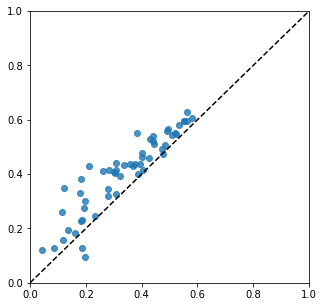

In [20]:
figSize(5, 5)

plt.scatter(scores_dict['linear'], scores_dict['RNN'], alpha = 0.8)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.plot([0, 1], [0, 1], linestyle = '--', color = 'k')

fig_path    = '/home/users/ghwilson/projects/nonstationarities/figures/'

#plt.savefig(fig_path + 'RNN/rnn_vs_meanrecalLinear.pdf')
plt.show()

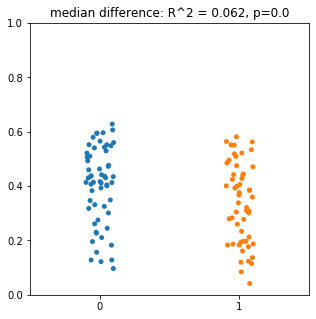

In [35]:
import seaborn as sns 

med_diff = np.median(scores_dict['RNN'] - scores_dict['linear']) 
pval     = scipy.stats.wilcoxon(scores_dict['RNN'], scores_dict['linear'])[1]

sns.stripplot(data = [x for x in scores_dict.values()])
plt.ylim([0, 1])
plt.title('median difference: R^2 = ' + str(np.round(med_diff, 3)) + ', p=' + str(np.round(pval, 3)))

plt.savefig(fig_path + 'RNN/rnn_vs_meanrecalLinear_wilcoxon.eps')
plt.show()